# 1. Setup

In [1]:
!pip install git+https://github.com/usgs/geomag-algorithms.git
!pip install git+https://github.com/samiriff/mars-ode-data-access.git

  Cloning https://github.com/usgs/geomag-algorithms.git to /tmp/pip-req-build-lw9f66xu
  Running command git clone -q https://github.com/usgs/geomag-algorithms.git /tmp/pip-req-build-lw9f66xu
     |████████████████████████████████| 23.9MB 3.3MB/s 
     |████████████████████████████████| 215kB 47.4MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-mc0i6nfu/wheels/dc/8b/cb/0141ac2aa76db65e2037c96bf61b63c26a64a1eb4ddb6f7eeb
  Stored in directory: /root/.cache/pip/wheels/11/d6/40/c448464ae42229b2f9fb46b71be0213e10e9628346b7f1198f
  Stored in directory: /root/.cache/pip/wheels/89/40/f5/7b4f2285aca871b5173887a6c69127210d92806c0d3a977e51
Successfully built geomag-algorithms obspy pycurl
  Cloning https://github.com/samiriff/mars-ode-data-access.git to /tmp/pip-req-build-_64x56j1
  Running command git clone -q https://github.com/samiriff/mars-ode-data-access.git /tmp/pip-req-build-_64x56j1
     |████████████████████████████████| 19.7MB 3.5MB/s 
     |████████████████████████████████| 20.1

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


# 2. Imports

In [0]:
from ode_data_access.query_processor import QueryProcessor
from ode_data_access.query_result_processor import QueryResultProcessor
import numpy as np
from fastai.vision import *
from fastai.imports import *
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import PIL
from pathlib import Path
import cv2
from tqdm import tqdm_notebook as tqdm
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# 3. Load Trained U-Net Model and Initialize Prediction utilities

In [86]:
!wget -O trained_unet.pkl https://files.slack.com/files-pri/TJRDXSH3L-FLE3AS5PC/download/trained_unet_762394.pkl?pub_secret=814d8c3b0a

--2019-07-25 08:03:02--  https://files.slack.com/files-pri/TJRDXSH3L-FLE3AS5PC/download/trained_unet_762394.pkl?pub_secret=814d8c3b0a
Resolving files.slack.com (files.slack.com)... 13.226.19.152
Connecting to files.slack.com (files.slack.com)|13.226.19.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129212486 (123M) [application/octet-stream]
Saving to: ‘trained_unet.pkl’

trained_unet.pkl    100%[===================>] 123.23M  18.8MB/s    in 6.5s    

2019-07-25 08:03:10 (18.9 MB/s) - ‘trained_unet.pkl’ saved [129212486/129212486]



In [0]:
def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [0]:
learn = load_learner('.', 'trained_unet.pkl')

In [0]:
classes = ['_background_', 'Crater', 'Dark Dune', 'Slope Streak', 'Bright Dune', 'Impact Ejecta', 'Swiss Cheese', 'Spider']
test_data = ImageDataBunch.single_from_classes('.', classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [0]:
tmp_path = Path('tmp')
if not os.path.exists(tmp_path):
  os.mkdir(tmp_path)

In [0]:
results_path = Path('results')
if not os.path.exists(results_path):
  os.mkdir(results_path)

In [0]:
def get_img_info(img_name):
  img = mpimg.imread(img_name)
  rows, cols = map(lambda x : x // 224, img.shape)
  img = PIL.Image.fromarray(img)  
  return img, rows, cols

In [0]:
def get_prediction(img):
  result_img = None
  for row in tqdm(range(cols)):
    horizontal_result_img = None
    for col in (range(rows)):
      area = (224 * row, 224 * col, 224 * (row + 1), 224 * (col + 1))
      cropped_img = img.crop(area)
      resized_img = cropped_img.resize((224, 224))
      resized_img.save(tmp_path/'test.jpg')

      pred = learn.predict(open_image(tmp_path/'test.jpg'))

      background = np.array(resized_img)
      foreground = np.uint8(np.squeeze(pred[0].data.numpy()) * 255)
      blended_img = cv2.addWeighted(background, 1, foreground, 0.5, 0)

      if horizontal_result_img is None:
        horizontal_result_img = blended_img
      else:
        horizontal_result_img = np.concatenate((horizontal_result_img, blended_img), axis=0)
    if result_img is None:
      result_img = horizontal_result_img
    else:
      result_img = np.concatenate((result_img, horizontal_result_img), axis=1)
  return result_img, pred

In [0]:
def get_result_name(img_name):
  tokens = img_name.split('.')
  tokens.insert(-1, 'result')
  return '.'.join(tokens)

In [0]:
def write_result(img_name, result_img):
  result_name = get_result_name(img_name)
  cv2.imwrite(str(results_path/result_name), result_img)

# 4. Query Processing for Mars ODE
- Run the following cells with different query parameters to download the required images
- Once you have got all the results you require, you can pass them through the model

In [98]:
# Query Parameters

# Basic Query Parameters
western_lon = 305  # Western longitude to look for the data, from 0 to 360
eastern_lon = 310  # Eastern longitude to look for the data, from 0 to 360
min_lat = 22  # Minimal latitude to look for the data, from -90 to 90
max_lat = 24  # Maximal latitude to look for the data, from -90 to 90
product_id = '*RED*'  # PDS Product Id to look for, with wildcards (*) allowed

# Advanced Query Parameters
target = 'mars'  # Aimed planetary body, i.e., Mars, Mercury, Moon, Phobos, or Venus
mission = 'MRO'  # Aimed mission, e.g., MGS or MRO
instrument = 'HIRISE'  # Aimed instrument from the mission, e.g., HIRISE or CRISM
product_type = 'RDRV11'  # Type of product to look for, e.g., DTM or RDRV11
min_ob_time = ''  # Minimal observation time in (even partial) UTC format, e.g., '2017-03-01'
max_ob_time = ''  # Maximal observation time in (even partial) UTC format, e.g., '2017-03-01'
file_name = '*RED.(NOMAP.thumb.jpg|LBL)'  # File name to look for, with wildcards (*) allowed
#file_name = '*RED.(JP2|LBL)'  # File name to look for, with wildcards (*) allowed
product_types = set(['PRODUCT DATA FILE', 'BROWSE', 'GREYSCALE THUMBNAIL'])  # Product types that will be downloaded, if found.
number_product_limit = 10  # Maximal number of products to return (100 at most)
result_offset_number = 0  # Offset the return products, to go beyond the limit of 100 returned products
remove_ndv = True  # Replace the no-data value as mentionned in the label by np.nan
bin_type = None # Type of binning used in image - Bin1 = 0.35 cm/pixel, Bin2 = 2xBin1, Bin4 = 2xBin2

# Chunk Settings
IS_CHUNKING_REQUIRED = False  # Flag that indicates whether the downloaded images will be chunkified - Set to True only while downloading JP2 images
SAVE_DIR_PREFIX = './chunks'
CHUNK_SIZE = 1024
SKIP_BLACK_IMAGES = True  # Set to False to retain all images that contain black pixels

# Default Settings to Align and Crop images with black margins
MAX_BORDER_SIZE = 200   # Border to be checked around the image
SAFETY_MARGIN = 0       # Removes extra pixels from the sides to make sure no black remains
TOLERANCE = 10          # A gray value is more likely to be considered black when you increase the tolerance
ALIGN_AND_CROP_THRESHOLDS = (MAX_BORDER_SIZE, SAFETY_MARGIN, TOLERANCE) # Set to None to prevent alignment and cropping

# Query Result Processing
query_processor = QueryProcessor()
query_results = query_processor.query_files_urls(target, mission, instrument, product_type,
                                                 western_lon, eastern_lon, min_lat, max_lat,
                                                 min_ob_time, max_ob_time, product_id, file_name,
                                                 number_product_limit, result_offset_number)
print("Total Number of Files of all bin types =", len(query_results.keys()))
query_result_processor = QueryResultProcessor()
should_continue = query_result_processor.download(query_results, bin_type, product_types)
if IS_CHUNKING_REQUIRED and should_continue:
  query_result_processor.process(SAVE_DIR_PREFIX, CHUNK_SIZE, SKIP_BLACK_IMAGES, ALIGN_AND_CROP_THRESHOLDS, vectorized_chunks)
print("Task Completed")

Query URL: http://oderest.rsl.wustl.edu/live2/?target=mars&ihid=MRO&iid=HIRISE&pt=RDRV11&westernlon=305&easternlon=310&minlat=22&maxlat=24&query=product&results=fp&output=XML&limit=10&offset=0&productid=*RED*
File URLs: OrderedDict([('https://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_045100_045199/ESP_045168_2045/ESP_045168_2045_RED.LBL', ('ESP_045168_2045_RED', 'PRODUCT LABEL FILE')), ('https://hirise.lpl.arizona.edu/PDS/EXTRAS/RDR/ESP/ORB_045100_045199/ESP_045168_2045/ESP_045168_2045_RED.NOMAP.thumb.jpg', ('ESP_045168_2045_RED', 'GREYSCALE THUMBNAIL')), ('https://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_046300_046399/ESP_046302_2025/ESP_046302_2025_RED.LBL', ('ESP_046302_2025_RED', 'PRODUCT LABEL FILE')), ('https://hirise.lpl.arizona.edu/PDS/EXTRAS/RDR/ESP/ORB_046300_046399/ESP_046302_2025/ESP_046302_2025_RED.NOMAP.thumb.jpg', ('ESP_046302_2025_RED', 'GREYSCALE THUMBNAIL')), ('https://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_048200_048299/ESP_048293_2040/ESP_048293_2040_RED.LBL', ('ESP_0482

# 5. Prediction

In [13]:
image_files = [file for file in os.listdir() if file.endswith('jpg')]
image_files

['ESP_048293_2040_RED.NOMAP.thumb.jpg',
 'AEB_000002_0000_RED.NOMAP.thumb.jpg',
 'ESP_046302_2025_RED.NOMAP.thumb.jpg',
 'ESP_045168_2045_RED.NOMAP.thumb.jpg']

In [14]:
image_names = [file for file in os.listdir() if file.endswith('jpg')]
for image_name in tqdm(image_names):
  img, rows, cols = get_img_info(image_name)
  print('Image =', image_name, ', Image Size =', img.size, ', Rows =', rows, ', Cols =', cols)
  result_img, pred = get_prediction(img)
  write_result(image_name, result_img)

Image = ESP_048293_2040_RED.NOMAP.thumb.jpg , Image Size = (512, 1423) , Rows = 6 , Cols = 2


Image = AEB_000002_0000_RED.NOMAP.thumb.jpg , Image Size = (512, 1947) , Rows = 8 , Cols = 2


Image = ESP_046302_2025_RED.NOMAP.thumb.jpg , Image Size = (512, 1985) , Rows = 8 , Cols = 2


Image = ESP_045168_2045_RED.NOMAP.thumb.jpg , Image Size = (512, 1702) , Rows = 7 , Cols = 2


In [15]:
dummy = np.uint8(np.squeeze(pred[0].data.numpy()) * 255)
dummy

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=uint8)

In [0]:
def dfs(img, row, col, visited):
  if row < 0 or col < 0 or row >= img.shape[0] or col >= img.shape[1]:
    return
  
  if visited[row][col] == 1:
    return
  
  visited[row][col] = 1
#   dfs(img, row + 1, col, visited)
#   dfs(img, row - 1, col, visited)
#   dfs(img, row, col + 1, visited)
#   dfs(img, row, col - 1, visited)

In [0]:
def get_object_count(img):
  count = 0
  visited = np.zeros_like(dummy)
  for row in range(img.shape[0]):
    for col in range(img.shape[1]):
      if img[row][col] != 0 and visited[row][col] != 1:
        dfs(img, row, col, visited)
        count += 1
  return count

In [0]:
get_object_count(dummy)

# 6. View Results

Text(0.5, 1.0, 'Result Image')

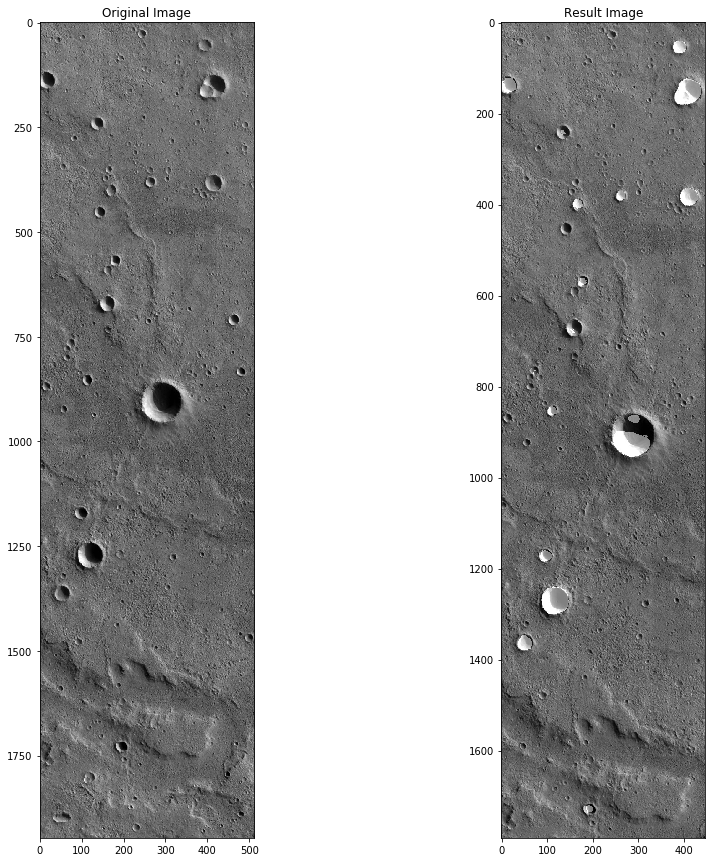

In [97]:
img_name = image_files[1]

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(mpimg.imread(img_name), cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(mpimg.imread(results_path/get_result_name(img_name)), cmap='gray')
ax[1].set_title('Result Image')

# Extras

## IMPORTANT: FOR REFERENCE ONLY - DO NOT RUN THESE CELLS

In [0]:
#@title Landing Site Coordinates
with open('../Landing_sites.csv', 'r') as f:
  lines = f.readlines()
  formatted_lines = []
  regex = re.compile(".*?\((.*?)\)")
  for line in lines:
    formatted_line = line.strip()
    formatted_line = re.sub("[\(\[].*?[\)\]]", "", formatted_line)
    formatted_lines.append(formatted_line.split(', '))
    
landing_sites = pd.DataFrame(formatted_lines, columns=['Mission', 'Latitude', 'Longitude', 'Status'])
landing_sites['Latitude'] = landing_sites['Latitude'].apply(convert_latitude)
landing_sites['Longitude'] = landing_sites['Longitude'].apply(convert_longitude)
landing_sites

,Mission,Latitude,Longitude,Status
0,Mars 2,-45,47.000000,Failed
1,Mars 3,-45,202.000000,Failed
2,Mars 6,-23.9,340.580000,Failed
3,Viking 1,22.48,310.030000,Successful
4,Mars Polar Lander,-76.57,165.200000,Failed
5,Pathfinder,19.33,326.450000,Successful
6,Beagle 2,10.6,90.000000,Failed
7,Spirit,-14.5719,175.478480,Successful
8,Opportunity,-1.9462,354.473400,Successful
9,Phoenix,68.218830,234.250778,Successful
